In [2]:
import torch
from compvit.factory import compvit_factory
from train_ft import LinearClassifierModel
from torchvision.datasets import ImageNet
import torchvision.transforms.v2 as tvt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from viz.token_viz_utils import hook_model, attn_processing

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import seaborn as sns
sns.set_theme("notebook")

/home/jajal/research/compvit-again/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/jajal/research/compvit-again/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/jajal/research/compvit-again/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/home/jajal/mambaforge/envs/neobase/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model, config = compvit_factory("compvitb14")

In [4]:
model = LinearClassifierModel(model, 1000)

In [5]:
model.load_state_dict(torch.load("best_performing.pth"))

<All keys matched successfully>

In [6]:
model = model.cuda().eval()

In [7]:
transform = tvt.Compose(
    [
        tvt.Resize(256, interpolation=tvt.InterpolationMode.BICUBIC),
        tvt.CenterCrop(224),
        tvt.ToTensor(),
        tvt.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

/home/jajal/mambaforge/envs/neobase/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
dataset = ImageNet(root="~/datasets/imagenet", split="val", )

In [9]:
x, y = dataset[5000]

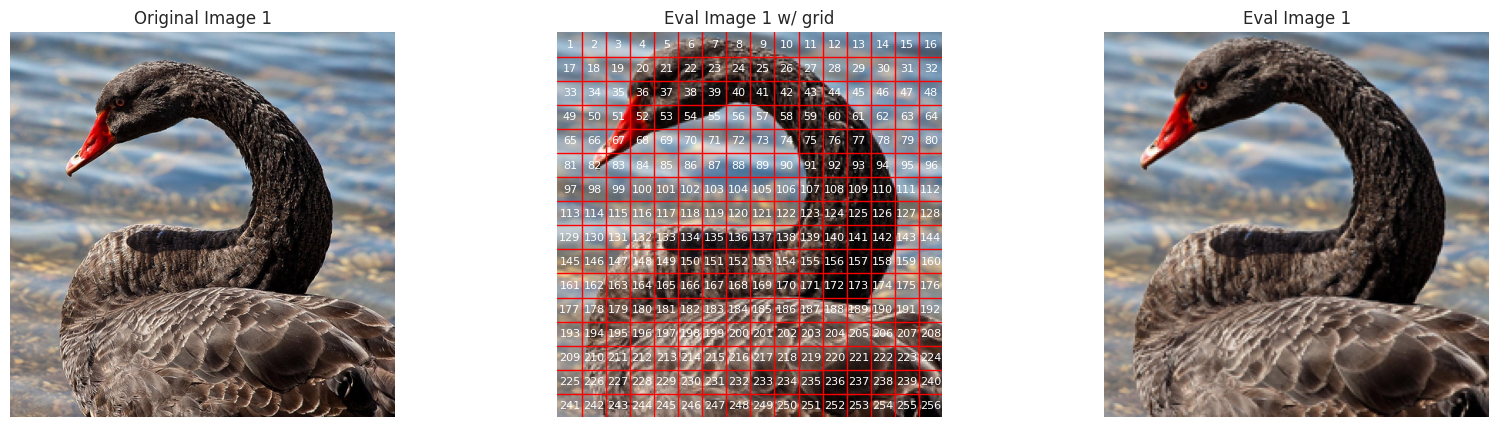

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot the first image
axs[0].imshow(x)
axs[0].axis('off')
axs[0].set_title('Original Image 1')

# Plot the second image
plot_xform = tvt.Compose(
    [
        tvt.Resize(256, interpolation=tvt.InterpolationMode.BICUBIC),
        tvt.CenterCrop(224),
    ]
)
axs[1].imshow(plot_xform(x))
axs[1].axis('off')
axs[1].set_title('Eval Image 1 w/ grid')

# Add grid to the second image
for i in range(1, 16):
    axs[1].axhline(y=i*14, color='red', linewidth=1)
    axs[1].axvline(x=i*14, color='red', linewidth=1)
for k in range(1, 16*16 + 1):
    i = (k - 1) // 16 + 1
    j = (k - 1) % 16 + 1
    axs[1].text(j*14 - 7, i*14 - 7, str(k), color='white', fontsize=8, ha='center', va='center')

# Plot the third image
axs[2].imshow(plot_xform(x))
axs[2].axis('off')
axs[2].set_title('Eval Image 1')

plt.show()

In [11]:
data = {}
hook_model(model, data)

In [12]:
torch.argmax(model.forward(transform(x).unsqueeze(0).cuda())), y

(tensor(100, device='cuda:0'), 100)

In [13]:
_ = model.model.forward(transform(x).unsqueeze(0).cuda(), get_attn=True)

In [14]:
block1_attn_map = data['model.compressor.block_1.attn'][1].squeeze()
block2_attn_map = data['model.compressor.block_2.attn'][1].squeeze()

In [15]:
block1_compression_data = attn_processing(block1_attn_map)
block2_compression_data = attn_processing(block2_attn_map)

In [16]:
def process_compression_data(data):
    processed_block_compression_data = {}
    for token, value in data.items():
        token_data = {}
        cum_weight = 0
        for _, head_data in value.items():
            topp_indices = head_data['topp_indices']
            topp_values = head_data['topp_values']
            cum_weight += sum(topp_values)
            token_data['cum_weight'] = cum_weight
            for idx, val in zip(topp_indices, topp_values):
                if idx in token_data:
                    token_data[idx] += val
                else:
                    token_data[idx] = val
        processed_block_compression_data[token] = token_data
    return processed_block_compression_data

In [17]:
processed_block1_data = process_compression_data(block1_compression_data)
processed_block1_data

{'out_token:0': {'cum_weight': 10.840963006019592,
  281: 2.2577603608369827,
  274: 0.6402912735939026,
  262: 3.8480539321899414,
  264: 3.2370775938034058,
  266: 0.1127413958311081,
  279: 0.7450384497642517},
 'out_token:1': {'cum_weight': 10.901979018002748,
  262: 3.717365078628063,
  281: 0.9889049679040909,
  274: 0.9580836892127991,
  264: 3.4651962369680405,
  288: 0.5813695713877678,
  266: 0.24521715939044952,
  287: 0.06026940420269966,
  237: 0.6457762122154236,
  173: 0.2397966980934143},
 'out_token:2': {'cum_weight': 10.736552376300097,
  262: 3.6166802123188972,
  281: 0.996149942278862,
  274: 0.9575211405754089,
  264: 3.8165852576494217,
  173: 0.09739413857460022,
  266: 0.06065414473414421,
  287: 0.03511772304773331,
  288: 0.26839587092399597,
  237: 0.7916924953460693,
  219: 0.09636145085096359},
 'out_token:3': {'cum_weight': 10.762726740911603,
  262: 4.377793446183205,
  281: 0.835655651986599,
  274: 0.6523300856351852,
  264: 3.9486370980739594,
  266: 

In [18]:
processed_block2_data = process_compression_data(block2_compression_data)
processed_block2_data

{'out_token:0': {'cum_weight': 10.881820794194937,
  16: 0.5082178115844727,
  120: 0.21531163156032562,
  17: 0.038953762501478195,
  241: 0.03789235278964043,
  70: 4.07012166082859,
  173: 1.105858825147152,
  219: 1.2463039457798004,
  262: 0.6502537727355957,
  264: 0.23826104402542114,
  51: 0.4841476082801819,
  157: 0.8584662452340126,
  67: 0.08167008310556412,
  275: 0.04573738947510719,
  279: 0.9440025836229324,
  274: 0.22314022481441498,
  236: 0.08089512586593628,
  237: 0.05258672684431076},
 'out_token:1': {'cum_weight': 11.242602407932281,
  52: 0.45193910598754883,
  264: 0.5662083923816681,
  285: 0.10464811325073242,
  70: 4.91374397277832,
  173: 1.5514175295829773,
  262: 0.6944867372512817,
  157: 1.332623541355133,
  279: 0.5583211779594421,
  274: 0.42415735125541687,
  219: 0.6450564861297607},
 'out_token:2': {'cum_weight': 11.364304155111313,
  264: 0.7442443519830704,
  52: 0.22967121005058289,
  67: 0.0887131541967392,
  70: 4.9597888588905334,
  173: 1.7

In [22]:
for token, value in processed_block1_data.items():
    idxs = list(filter(lambda x: x != "cum_weight", value))
    print(token, f" || num_comp: {len(idxs)} ||", idxs)

out_token:0  || num_comp: 6 || [281, 274, 262, 264, 266, 279]
out_token:1  || num_comp: 9 || [262, 281, 274, 264, 288, 266, 287, 237, 173]
out_token:2  || num_comp: 10 || [262, 281, 274, 264, 173, 266, 287, 288, 237, 219]
out_token:3  || num_comp: 14 || [262, 281, 274, 264, 266, 288, 237, 279, 236, 287, 219, 285, 221, 283]
out_token:4  || num_comp: 8 || [262, 274, 281, 264, 266, 173, 287, 237]
out_token:5  || num_comp: 28 || [262, 281, 264, 274, 275, 266, 280, 260, 278, 82, 287, 263, 276, 277, 284, 237, 236, 219, 221, 285, 173, 279, 283, 252, 98, 282, 192, 289]
out_token:6  || num_comp: 13 || [262, 264, 274, 281, 276, 266, 287, 236, 237, 219, 279, 221, 285]
out_token:7  || num_comp: 19 || [262, 264, 281, 260, 275, 280, 278, 274, 266, 276, 67, 284, 263, 277, 287, 279, 285, 237, 283]
out_token:8  || num_comp: 15 || [264, 289, 278, 262, 276, 277, 275, 274, 281, 287, 266, 288, 279, 237, 236]
out_token:9  || num_comp: 11 || [264, 262, 281, 274, 82, 260, 275, 278, 276, 287, 266]
out_token:10

In [23]:
for token, value in processed_block2_data.items():
    idxs = list(filter(lambda x: x != "cum_weight", value))
    
    print(token, f" || num_comp: {len(idxs)} ||", idxs)

out_token:0  || num_comp: 17 || [16, 120, 17, 241, 70, 173, 219, 262, 264, 51, 157, 67, 275, 279, 274, 236, 237]
out_token:1  || num_comp: 10 || [52, 264, 285, 70, 173, 262, 157, 279, 274, 219]
out_token:2  || num_comp: 10 || [264, 52, 67, 70, 173, 262, 157, 279, 274, 219]
out_token:3  || num_comp: 14 || [285, 283, 282, 260, 264, 70, 237, 173, 219, 262, 67, 51, 279, 157]
out_token:4  || num_comp: 10 || [52, 67, 70, 173, 262, 264, 157, 279, 274, 219]
out_token:5  || num_comp: 12 || [52, 283, 285, 70, 237, 173, 219, 262, 67, 51, 279, 157]
out_token:6  || num_comp: 14 || [52, 285, 283, 70, 237, 173, 219, 262, 67, 264, 51, 279, 157, 135]
out_token:7  || num_comp: 15 || [283, 52, 285, 70, 237, 173, 219, 274, 262, 67, 51, 279, 157, 260, 236]
out_token:8  || num_comp: 15 || [283, 285, 52, 282, 70, 237, 173, 262, 67, 264, 51, 279, 157, 219, 135]
out_token:9  || num_comp: 16 || [52, 283, 237, 70, 281, 173, 219, 274, 279, 276, 262, 264, 51, 67, 157, 236]
out_token:10  || num_comp: 17 || [283, 52